# Importaciones y datos

In [35]:
# Datasets
import pandas as pd
# Rutas
import os
from pathlib import Path
# Operaciones
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import scipy.stats as stats
from scipy.stats import norm
# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
# Modelo
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
# Importamos los datos
notebook_path = os.path.abspath('')
current_dir = Path(notebook_path)
data_dir = current_dir.parent/'archivos'/'archivos_formateados'

ruta_luz = data_dir/'precio-luz-conformato.csv'
ruta_eolica = data_dir/'generacion-eolica-conformato.csv'
ruta_solar = data_dir/'generacion-solar-conformato.csv'
ruta_demanda = data_dir/'demanda-real-conformato.csv'

precio_luz = pd.read_csv(ruta_luz)
generacion_eolica = pd.read_csv(ruta_eolica)
generacion_solar = pd.read_csv(ruta_solar)
demanda_real = pd.read_csv(ruta_demanda)

Para dar formato a los DataSets hacemos lo siguiente:
- Marcamos una fecha de final por si los datos no acban en el mismo día
- Introducimos un desfase en las varaibles exógenas para evitar el data leaking en el modelo
- Añadimos otras variables como la media diaria y su desviación, la hora anterior, del día previo, etc.
- Añadimos medias móviles y std para las variables precio, generaciones y demanda (esta parte es un modelo distinto, comentar si no lo queremos)

In [36]:
# Marcamos una fecha de fin por si los conjuntos terminan en días distintos
fecha_fin = pd.to_datetime('2025-06-30T23:00:00+02:00').tz_convert('UTC')

# Función para formatear los DataFrames
def process_time_series_df(df, value_col, end_date):
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
    df = df.set_index('datetime').asfreq('h')
    df[value_col] = pd.to_numeric(df[value_col], errors='coerce')
    return df.loc[:end_date].dropna(subset=[value_col])

precio_luz = process_time_series_df(precio_luz, 'precio', fecha_fin)
generacion_eolica = process_time_series_df(generacion_eolica, 'generacion', fecha_fin)
generacion_solar = process_time_series_df(generacion_solar, 'generacion', fecha_fin)
demanda_real = process_time_series_df(demanda_real, 'demanda', fecha_fin)

df = precio_luz.copy()
# Variar el shift en función de los que queramos de desfase en las varaibles exógenas
df['generacion_eolica'] = generacion_eolica['generacion'].shift(24)
df['generacion_solar'] = generacion_solar['generacion'].shift(24)
df['demanda_real'] = demanda_real['demanda'].shift(24)
df = df.dropna()

# Creamos los features adicionales del modelo
def create_features(df):
    df = df.copy()
    df['hora'] = df.index.hour
    df['dia_semana'] = df.index.dayofweek
    df['mes'] = df.index.month
    df['lag_1'] = df['precio'].shift(1)
    df['lag_24'] = df['precio'].shift(24)
    df['lag_168'] = df['precio'].shift(168)
    df['rolling_mean_24'] = df['precio'].rolling(24).mean()
    df['rolling_std_24'] = df['precio'].rolling(24).std()
    df['rolling_mean_24_eolica'] = df['generacion_eolica'].rolling(24).mean()
    df['rolling_std_24_eolica'] = df['generacion_eolica'].rolling(24).std()
    df['rolling_mean_24_solar'] = df['generacion_solar'].rolling(24).mean()
    df['rolling_std_24_solar'] = df['generacion_solar'].rolling(24).std()
    df['rolling_mean_24_demanda'] = df['demanda_real'].rolling(24).mean()
    df['rolling_std_24_demanda'] = df['demanda_real'].rolling(24).std()
    return df.dropna()

df_feat = create_features(df)

Vamos a definir los conjuntos sobre los que operaremos:
- Fijamos un conjunto de predicción sobre el que realizaremos un forecasting con el modelo entrenado
- Train y test set, que abarcan un 95/5% de los datos restantes

In [37]:
# Generamos un conjunto sobre el que haremos la predicción, eligiendo las fechas de inicio y fin
intervalo_prediccion_inicio = pd.to_datetime("2025-06-01T00:00:00+00:00")
intervalo_prediccion_fin = pd.to_datetime("2025-06-30T23:00:00+00:00")
prediccion = df_feat[(df_feat.index >= intervalo_prediccion_inicio) & (df_feat.index <= intervalo_prediccion_fin)]

# Nos quedamos con el resto del conjunto
df_no_prediccion = df_feat[df_feat.index < intervalo_prediccion_inicio]
# Creamos unas variables para separar las exógenas y endógenas para reentrenar después
X_total = df_no_prediccion.drop(columns='precio').select_dtypes(include=['number'])
Y_total = df_no_prediccion['precio']

# Lo separamos en train y test
split_idx = int(len(df_no_prediccion) * 0.9)
train = df_no_prediccion.iloc[:split_idx]
test = df_no_prediccion.iloc[split_idx:]

# Creamos las variables endógenas y exógenas para el entrenamiento y test
X_train = train.drop(columns='precio').select_dtypes(include=['number'])
Y_train = train['precio']
X_test = test.drop(columns='precio').select_dtypes(include=['number'])
Y_test = test['precio']
X_prediccion = prediccion.drop(columns='precio').select_dtypes(include=['number'])
Y_prediccion = prediccion['precio']

# Análisis exploratorio

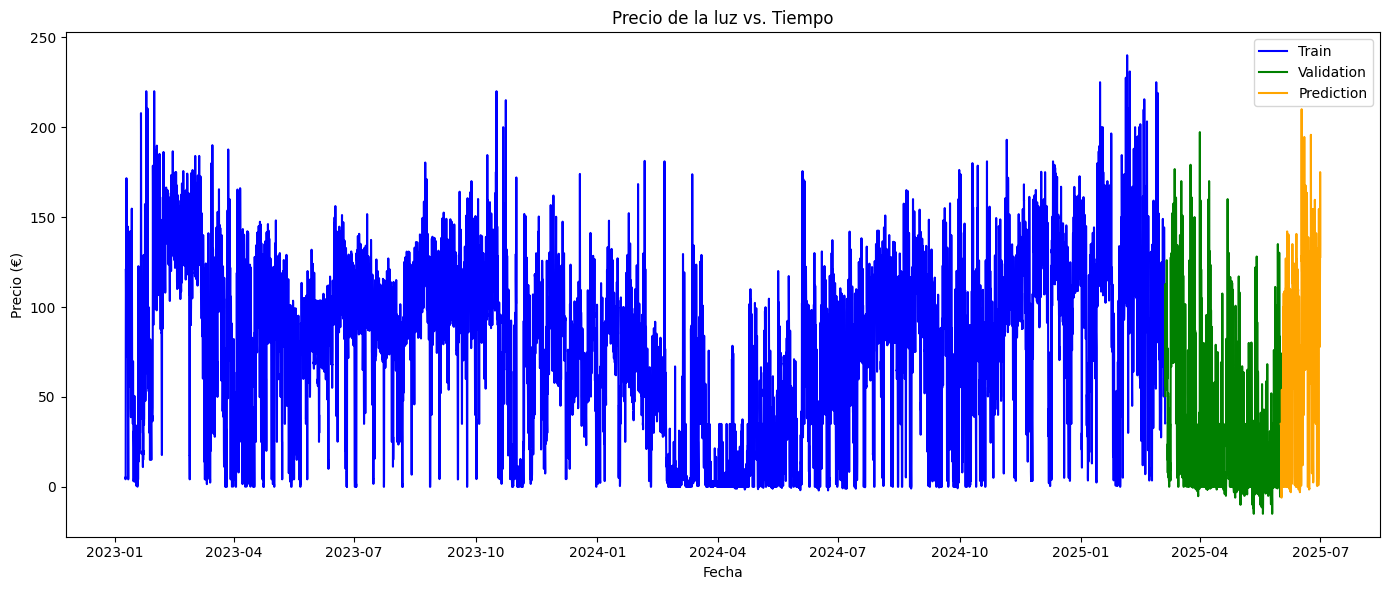

In [38]:
# Graficamos directamente la serie de precios
plt.figure(figsize=(14, 6))
plt.plot(X_train.index, Y_train, label='Train', color='blue')
plt.plot(X_test.index, Y_test, label='Validation', color='green')
plt.plot(X_prediccion.index, Y_prediccion, label='Prediction', color='orange')
plt.title('Precio de la luz vs. Tiempo')
plt.ylabel('Precio (€)')
plt.xlabel('Fecha')
plt.legend()
plt.tight_layout()
plt.show()

Observamos en los boxplots que:
- Las horas valle son al medio día y en los meses de marzo, abril y mayo
- Las horas pico son a primeras horas del día (06:00) y por la tarde (19:00)

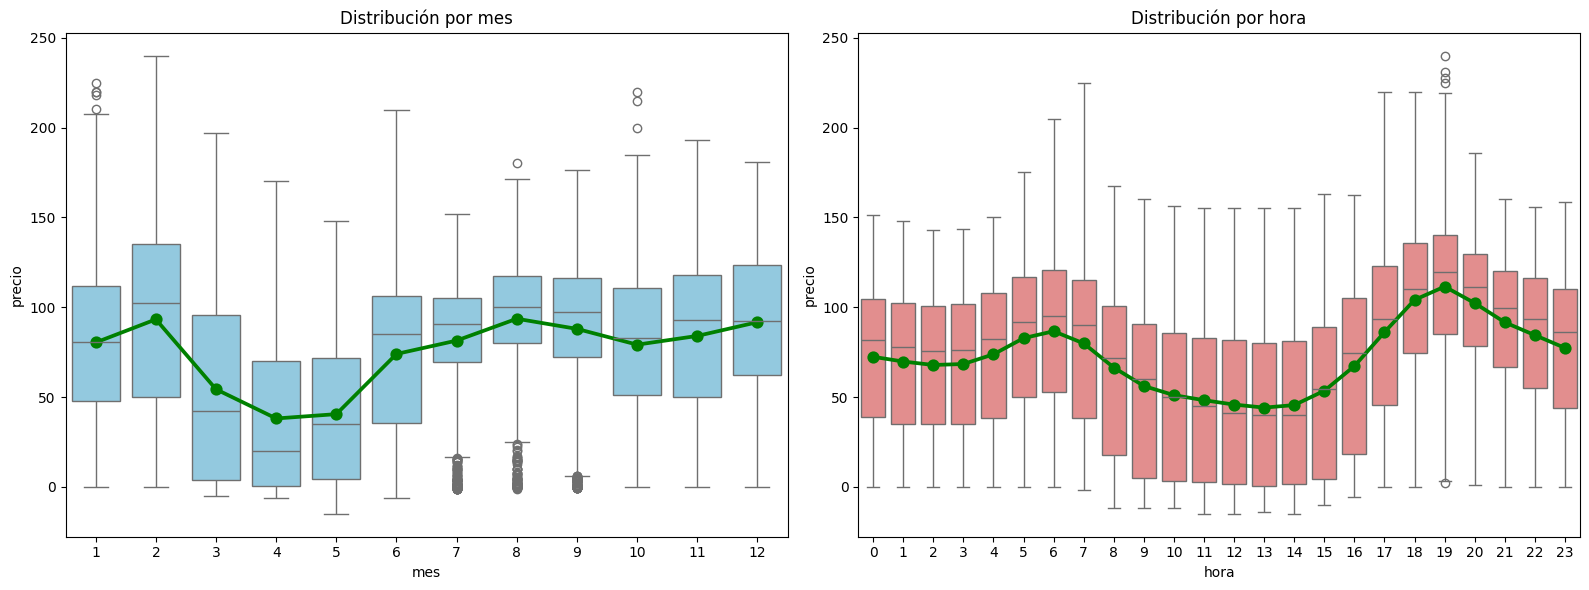

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(x='mes', y='precio', data=df_feat, ax=axs[0], color='skyblue')
sns.pointplot(x='mes', y='precio', data=df_feat, ax=axs[0], estimator='mean', color='green', markers='o', linestyles='-', errorbar=None)
axs[0].set_title("Distribución por mes")
sns.boxplot(x='hora', y='precio', data=df_feat, ax=axs[1], color='lightcoral')
sns.pointplot(x='hora', y='precio', data=df_feat, ax=axs[1], estimator='mean', color='green', markers='o', linestyles='-', errorbar=None)
axs[1].set_title("Distribución por hora")
plt.tight_layout()
plt.show()

La matriz de correlación nos muestra la relación entre las variables, en este caso nos interesa ver que tenemos valores intermedios entre la endógena y las exógenas, sin llegar a extremos cercanos a 1.

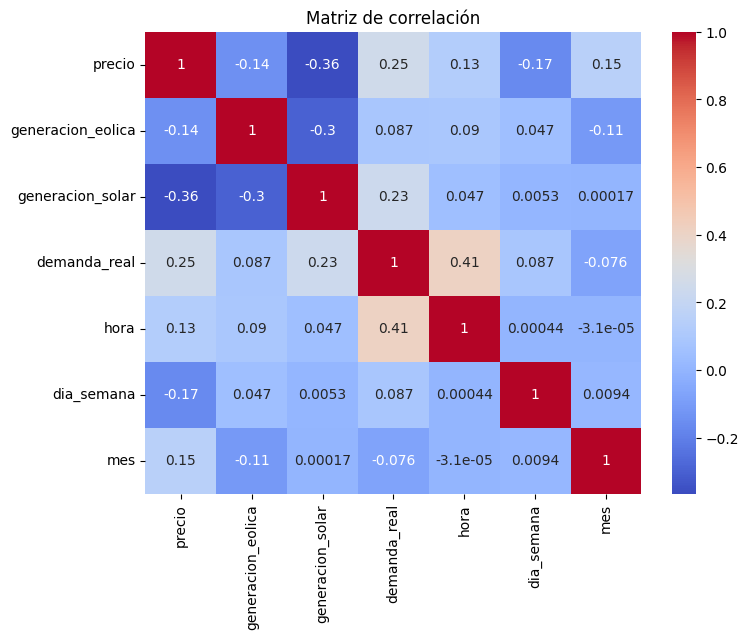

In [40]:
# Matriz de correlación
plt.figure(figsize=(8,6))
sns.heatmap(df_feat[['precio', 'generacion_eolica', 'generacion_solar', 'demanda_real', 'hora', 'dia_semana', 'mes']].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

# Entrenamiendo

## GridSearch + TimeSeriesSplit 

Aplicamos un GridSearch para encontrar los hiperparámetros que mejor funcionan, no introduciendo un gran grado de complejidad para evitar perder generalización en el modelo. El TimeSeriesSplit se utiliza para particionar nuestro conjunto de entrenamiento y realizar sobre éstos los test, de manera que obtenemos errores en diferentes momentos del histórico y podemos promediarlos.

In [ ]:
param_grid = {
    'n_estimators': [300, 325, 350, 375, 400, 425, 450],
    'learning_rate': [0.02, 0.03, 0.04, 0.05, 0.06, 0.07],
    'max_depth': [2, 3, 4, 5]
}

tscv = TimeSeriesSplit(n_splits=5) 

xgb = XGBRegressor(random_state=42, reg_alpha=5, reg_lambda=1)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1,
    verbose=2
)
print("------------------------------------")
print("Iniciando búsqueda de hiperparámetros con GridSearchCV...")
print("------------------------------------")
grid_search.fit(X_train, Y_train)
print("<------------ VALORES DE LOS ERRORES ------------>")
print(f"Mejores hiperparámetros encontrados: {grid_search.best_params_}")
print(f"Mejor MAE con validación cruzada: {-grid_search.best_score_:.2f}")
print("------------------------------------")


------------------------------------
Iniciando búsqueda de hiperparámetros con GridSearchCV...
------------------------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
<------------ VALORES DE LOS ERRORES ------------>
Mejores hiperparámetros encontrados: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 300}
Mejor MAE con validación cruzada: 6.50
------------------------------------


In [42]:
best_model = grid_search.best_estimator_

# Predecimos en el conjunto de test
Y_test_pred = best_model.predict(X_test)

## Evaluación

Evaluamos el modelo, mostrando el MAE y RMSE de test y las contribuciones de las variables exógenas introducidas. Observamos que la más significativa es el lag_1, es decir, que lo que más se tiene en cuenta para calcular el precio es el que tenía en la hora anterior.

In [43]:
# Evaluamos el rendimiento en el conjunto de test
print(" Evaluación sobre el modelo test:")
print("------------------------------------")
print(f"MAE: {mean_absolute_error(Y_test, Y_test_pred):.4f}")
print(f"RMSE: {root_mean_squared_error(Y_test, Y_test_pred):.4f}")
print(f"R²: {r2_score(Y_test, Y_test_pred):.4f}")

 Evaluación sobre el modelo test:
------------------------------------
MAE: 7.2988
RMSE: 12.2359
R²: 0.8922


## Graficamos el train set con su predicción

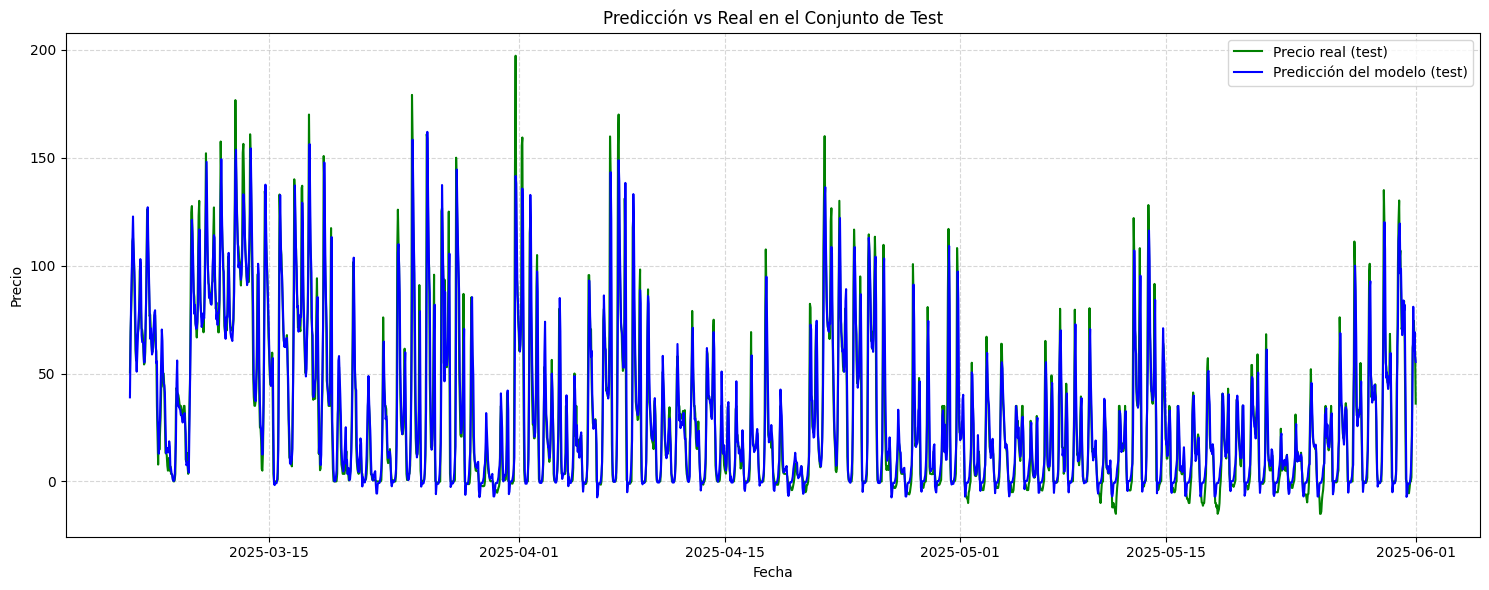

In [44]:
plt.figure(figsize=(15, 6))
plt.plot(Y_test.index, Y_test, label='Precio real (test)', color='green')
plt.plot(Y_test.index, Y_test_pred, label='Predicción del modelo (test)', color='blue')
plt.title("Predicción vs Real en el Conjunto de Test")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Errores en la predicción del conjunto test

Observamos que los errores no son normales pero están más o menos bien distribuidos, con una desviación típica de 10.38 para el conjunto test

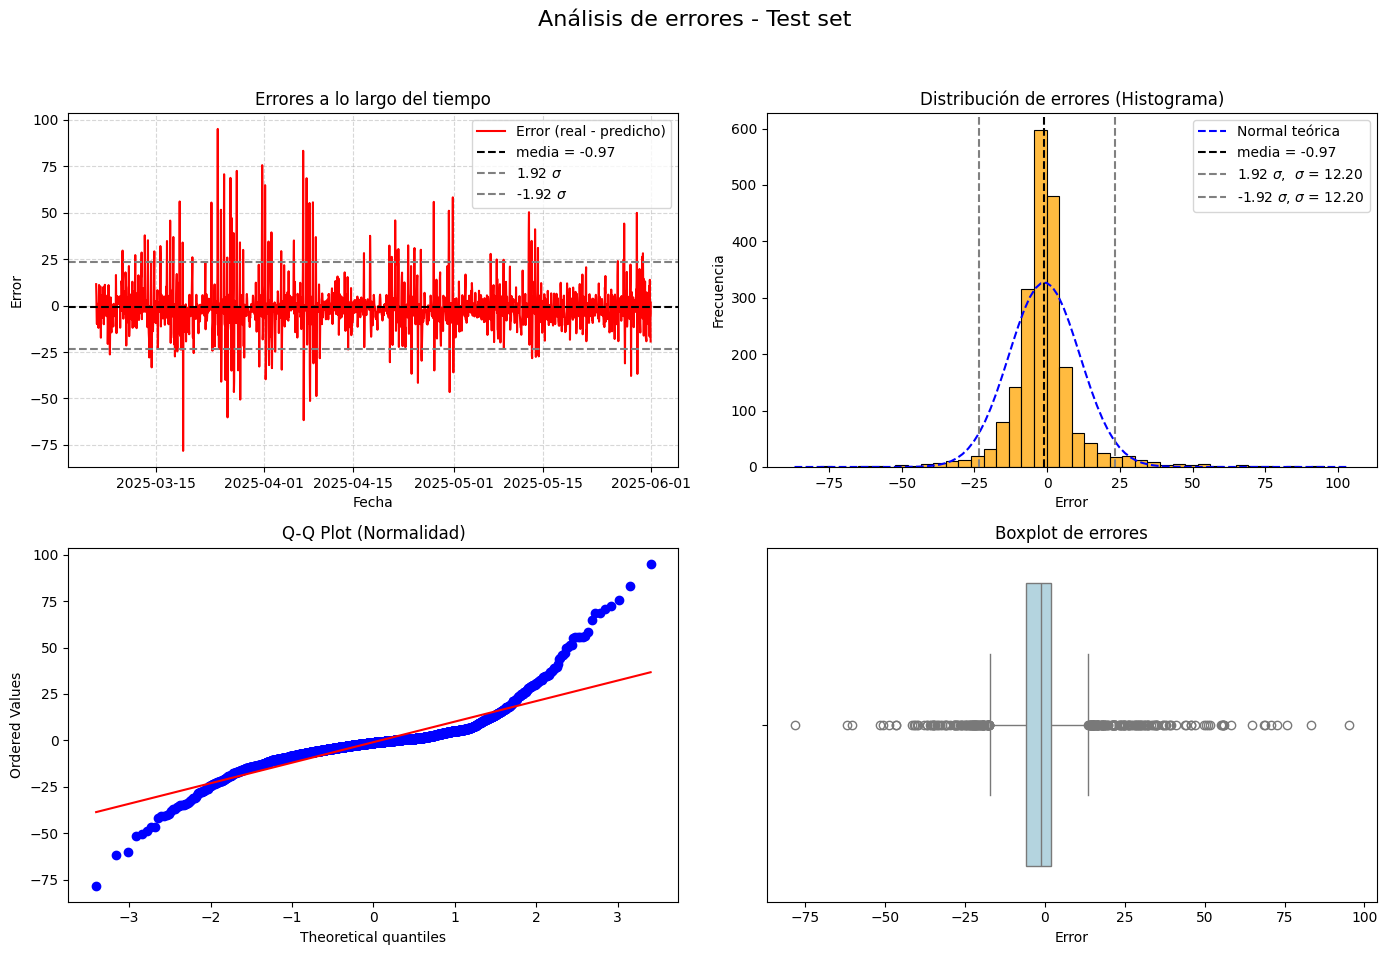

In [45]:
errores_test = Y_test - Y_test_pred

media = np.mean(errores_test)
desviacion = np.std(errores_test)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análisis de errores - Test set', fontsize=16)

# Gráfica normal
axs[0, 0].plot(errores_test.index, errores_test, color='red', label='Error (real - predicho)')
axs[0, 0].axhline(media, linestyle='--', color='black', label=f"media = {media:.2f}")
axs[0, 0].axhline(1.92*desviacion, linestyle='--', color='grey', label='1.92 $\\sigma$')
axs[0, 0].axhline(-1.92*desviacion, linestyle='--', color='grey', label='-1.92 $\\sigma$')
axs[0, 0].set_title('Errores a lo largo del tiempo')
axs[0, 0].set_xlabel('Fecha')
axs[0, 0].set_ylabel('Error')
axs[0, 0].legend()
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# Histograma
sns.histplot(errores_test, bins=40, kde=False, color='orange', edgecolor='black', ax=axs[0, 1])
xmin, xmax = axs[0, 1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, media, desviacion)
axs[0, 1].plot(x, p * len(errores_test) * (xmax-xmin)/40, 'b--', label='Normal teórica')

axs[0, 1].axvline(media, linestyle='--', color='black', label=f"media = {media:.2f}")
axs[0, 1].axvline(1.92*desviacion, linestyle='--', color='grey', label=f'1.92 $\\sigma$,  $\\sigma$ = {desviacion:.2f}')
axs[0, 1].axvline(-1.92*desviacion, linestyle='--', color='grey', label=f'-1.92 $\\sigma$, $\\sigma$ = {desviacion:.2f}')
axs[0, 1].set_title('Distribución de errores (Histograma)')
axs[0, 1].set_xlabel('Error')
axs[0, 1].set_ylabel('Frecuencia')
axs[0, 1].legend()

# Q-Q Plot
stats.probplot(errores_test, dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot (Normalidad)')

# Boxplot
sns.boxplot(x=errores_test, color='lightblue', ax=axs[1, 1])
axs[1, 1].set_title('Boxplot de errores')
axs[1, 1].set_xlabel('Error')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Predicción

In [46]:
# Reentrenamos el modelo con todo el conjunto de datos
best_model.fit(X_total, Y_total)
Y_prediccion_pred = best_model.predict(X_prediccion)

## Evaluamos el modelo

In [47]:
# Evaluamos el rendimiento en la predicción
mae_test = mean_absolute_error(Y_prediccion, Y_prediccion_pred)
rmse_test = root_mean_squared_error(Y_prediccion, Y_prediccion_pred)
r2_test = r2_score(Y_prediccion, Y_prediccion_pred)

print(" Evaluación sobre el modelo test:")
print("------------------------------------")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")

 Evaluación sobre el modelo test:
------------------------------------
MAE: 7.7443
RMSE: 12.9418
R²: 0.9366


## Graficamos la prediccion

Podemos generar unos intervalos de confianza a partir de boostraping, esta parte está comentada y es por si se quiere, en la predicción final, implementarlos.

In [48]:
n_bootstraps = 50
boot_preds = np.zeros((n_bootstraps, len(X_prediccion)))

np.random.seed(42)
for i in range(n_bootstraps):
    sample_idx = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_train_boot = X_train.iloc[sample_idx]
    y_train_boot = Y_train.iloc[sample_idx]
    
    model_boot = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
    model_boot.fit(X_train_boot, y_train_boot)
    boot_preds[i, :] = model_boot.predict(X_prediccion)
    print(f"Bootstrap {i+1}/{n_bootstraps}", end='\r')

lower_bound = np.percentile(boot_preds, 2.5, axis=0)
upper_bound = np.percentile(boot_preds, 97.5, axis=0)

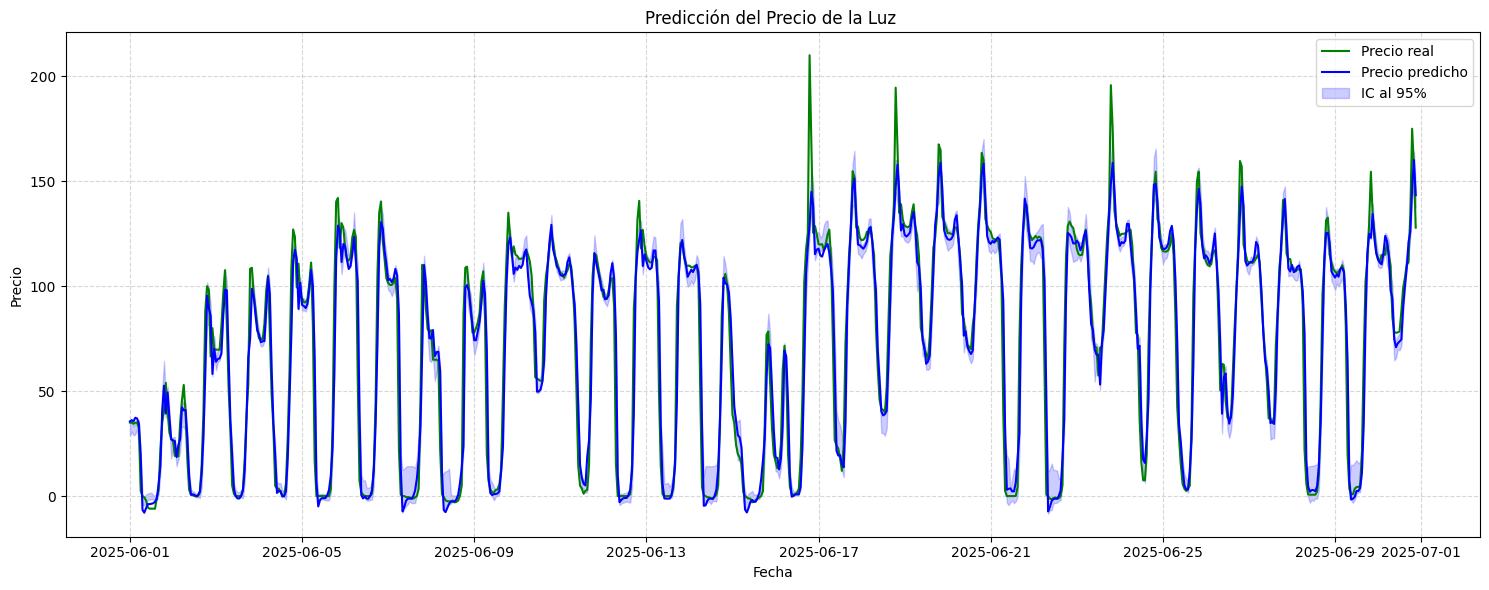

In [49]:
plt.figure(figsize=(15, 6))
plt.plot(prediccion.index, Y_prediccion, label='Precio real', color='green')
plt.plot(prediccion.index, Y_prediccion_pred, label='Precio predicho', color='blue')
plt.fill_between(prediccion.index, lower_bound, upper_bound, color='blue', alpha=0.2, label='IC al 95%')
plt.title("Predicción del Precio de la Luz ")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Hago zoom en un día

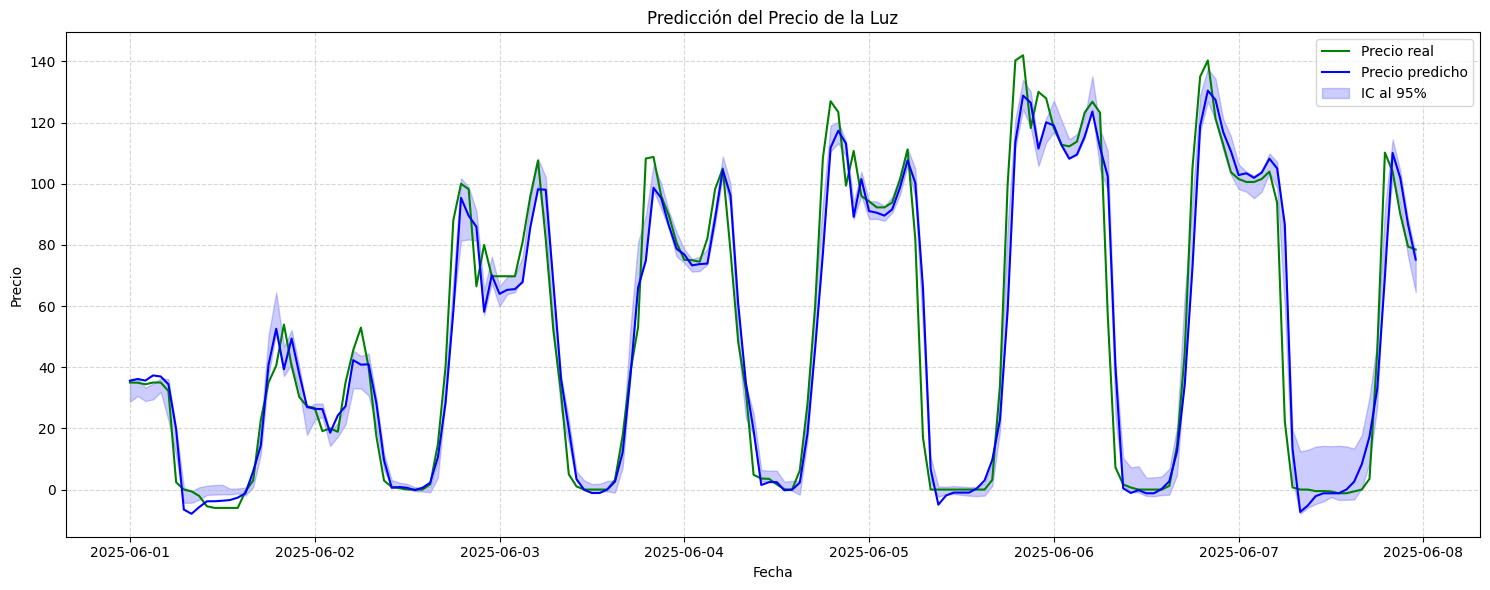

In [50]:
n = 24*7
prediccion_n = prediccion.iloc[:n]
Y_prediccion_n = Y_prediccion.iloc[:n]
Y_prediccion_pred_n = Y_prediccion_pred[:n]
lower_bound_n = lower_bound[:n]
upper_bound_n = upper_bound[:n]

plt.figure(figsize=(15, 6))
plt.plot(prediccion_n.index, Y_prediccion_n, label='Precio real', color='green')
plt.plot(prediccion_n.index, Y_prediccion_pred_n, label='Precio predicho', color='blue')
plt.fill_between(prediccion_n.index, lower_bound_n, upper_bound_n, color='blue', alpha=0.2, label='IC al 95%')
plt.title("Predicción del Precio de la Luz")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Errores en el conjunto de predicción

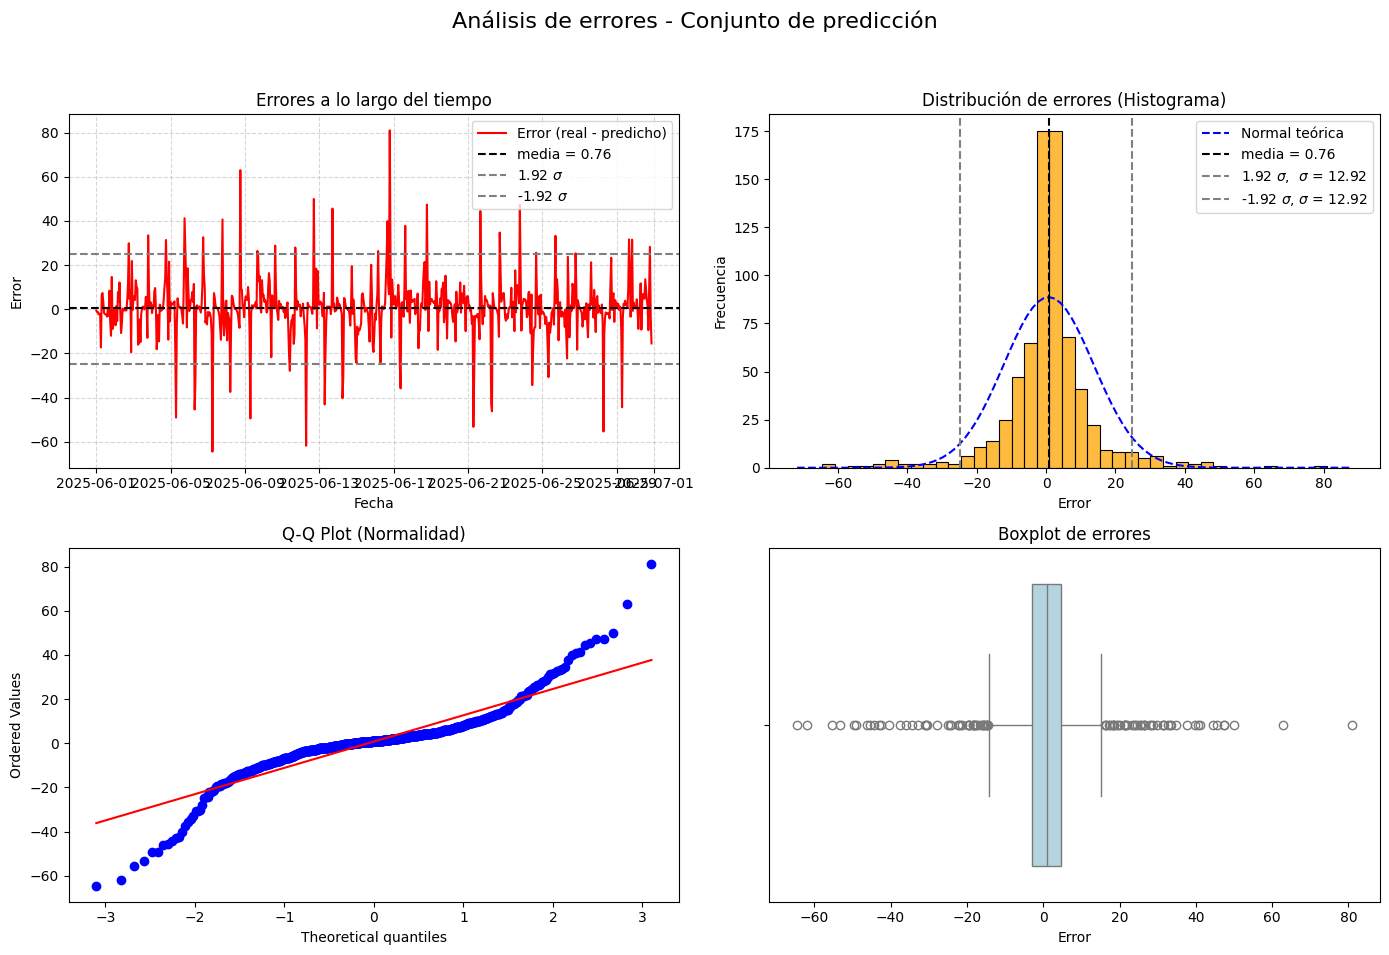

In [51]:
errores_pred = Y_prediccion - Y_prediccion_pred

media = np.mean(errores_pred)
desviacion = np.std(errores_pred)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análisis de errores - Conjunto de predicción', fontsize=16)

# Gráfica normal
axs[0, 0].plot(errores_pred.index, errores_pred, color='red', label='Error (real - predicho)')
axs[0, 0].axhline(media, linestyle='--', color='black', label=f"media = {media:.2f}")
axs[0, 0].axhline(1.92*desviacion, linestyle='--', color='grey', label='1.92 $\\sigma$')
axs[0, 0].axhline(-1.92*desviacion, linestyle='--', color='grey', label='-1.92 $\\sigma$')
axs[0, 0].set_title('Errores a lo largo del tiempo')
axs[0, 0].set_xlabel('Fecha')
axs[0, 0].set_ylabel('Error')
axs[0, 0].legend()
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# Histograma
sns.histplot(errores_pred, bins=40, kde=False, color='orange', edgecolor='black', ax=axs[0, 1])
xmin, xmax = axs[0, 1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, media, desviacion)
axs[0, 1].plot(x, p * len(errores_pred) * (xmax-xmin)/40, 'b--', label='Normal teórica')

axs[0, 1].axvline(media, linestyle='--', color='black', label=f"media = {media:.2f}")
axs[0, 1].axvline(1.92*desviacion, linestyle='--', color='grey', label=f'1.92 $\\sigma$,  $\\sigma$ = {desviacion:.2f}')
axs[0, 1].axvline(-1.92*desviacion, linestyle='--', color='grey', label=f'-1.92 $\\sigma$, $\\sigma$ = {desviacion:.2f}')
axs[0, 1].set_title('Distribución de errores (Histograma)')
axs[0, 1].set_xlabel('Error')
axs[0, 1].set_ylabel('Frecuencia')
axs[0, 1].legend()

# Q-Q Plot
stats.probplot(errores_pred, dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot (Normalidad)')

# Boxplot
sns.boxplot(x=errores_pred, color='lightblue', ax=axs[1, 1])
axs[1, 1].set_title('Boxplot de errores')
axs[1, 1].set_xlabel('Error')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
